In [1]:
from bs4 import BeautifulSoup
import requests
import re
import os
import csv
import pandas as pd
import numpy as np

# Retrieve article urls

## Using a generator

The method below is a "generator" method, which can be used to generate urls for a specific topic. 

If you want to use it to generate urls, first create a generator method object, and then pass this obejcet to the `next` method each time you want a new url:

    gen = article_url_generator("some topic")
    article_url = next(gen)
    
Alternatively, you can loop over all article urls like this:

    for article_url in article_url_generator():
        ...


In [2]:
def article_url_generator(tag, max_count=None):
    base_url = "https://www.engadget.com"
    page = 1
    while 1:
        url = base_url + "/tag/{}/page/{}/".format(tag, page)
        soup = BeautifulSoup(requests.get(url).text, "html.parser")
        
        # This is the top article - treat it differently
        article = soup.find("article")
        if article:
            article_url_tag = article.find("a")
            if article_url_tag is not None:
                yield base_url + article_url_tag['href']
        else:
            break
        
        # All other article url's are found using this approach
        for article_url_tag in soup.find_all("a", class_="o-hit__link"):
            yield base_url + article_url_tag['href']
            
        # Move to the next page
        page += 1

In [3]:
gen = article_url_generator("ai")
for i in range(2):
    print(next(gen))

https://www.engadget.com/2017/04/06/facebook-m-suggestions/
https://www.engadget.com/2017/04/05/ai-predicts-stem-cell-layouts/


## Using a normal method

You can also just create a normal method, but this will retrieve all the article urls before you need them

In [4]:
def get_article_urls(tag, num_pages):
    urls = []
    base_url = "https://www.engadget.com"
    for page in range(1, num_pages+1):
        url = base_url + "/tag/{}/page/{}/".format(tag, page)
        soup = BeautifulSoup(requests.get(url).text, "html.parser")
        
        # This is the top article - treat it differently
        article = soup.find("article")
        if article:
            article_url_tag = article.find("a")
            if article_url_tag is not None:
                urls.append(base_url + article_url_tag['href'])
        else:
            break
        
        # All other article url's are found using this approach
        for article_url_tag in soup.find_all("a", class_="o-hit__link"):
            urls.append(base_url + article_url_tag['href'])
            
    return urls

In [5]:
article_urls = get_article_urls("ai", 2)
for i in range(2):
    print(article_urls[i])

https://www.engadget.com/2017/04/06/facebook-m-suggestions/
https://www.engadget.com/2017/04/05/ai-predicts-stem-cell-layouts/


# Extracting the article body

The following method is used to extract the article body from the BeautifulSoup-object (`soup`). Note that each part of the body may have substrings, so this is why we need to iterate through all the `strings` of the body elements.

In [6]:
def extract_article_body(soup):
    body = ""
    for article_text in soup.find_all("div", class_=re.compile("article-text")):
        for paragraph in article_text.find_all("p"):
            for s in paragraph.strings:
                body += " " + s
    body = re.sub(" (?=[.!?])", "", body)
    body = " ".join(body.split())
    return body.strip()

In [7]:
urls = get_article_urls("ai", 1)
soup = BeautifulSoup(requests.get(urls[0]).text, "html.parser")
extract_article_body(soup)

'A couple of years ago, Facebook introduced M , an AI-powered personal assistant for Messenger. The idea behind M is that you could ask it to do pretty much anything -- book flights, cancel your cable service and even find a plumber -- and it\'ll do it for you, with the occasional help from human beings. It was rolled out to just a small test market of users in San Francisco, but we\'ve not heard much about it since then. Until now. Today, Facebook has announced that a version of M will finally be available to all Messenger users in the US. It\'s called " M suggestions ," and it\'ll essentially pop up at certain points of your Messenger conversation to recommend related content or features. In this initial rollout phase, suggestions from M will center around just a few features: stickers, payments, location, making plans, polls and getting a ride. So if you say "Happy birthday," M might pop up a row of stickers featuring balloons and cake. If your friend says "pay me $10," M would then

# Retrieving an article

When retrieving an article, we want the following:
- The **title** of the article
- The **preamble** (introduction) of the article
- The **body** (main part) of the article
- The **author** of the article
- The **time** the article was published

In [8]:
def get_article(url):
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    article = {}
    
    # Get the title of the article
    article["title"] = soup.title.get_text()
    
    # Get the preamble of the article
    try:
        article["preamble"] = soup.find("div", class_=re.compile("t-d7@m-")).get_text().strip()
    except AttributeError:
        article["preamble"] = ""
    
    # Get the body of the article
    article["body"] = extract_article_body(soup)
    
    # Get the author of the article
    article["author"] = soup.find("meta", {"name": "blogger_name"}).get("content")
    
    # Publish time
    article["time"] = soup.find("meta", {"name": "published_at"}).get("content")
        
    return article

In [9]:
urls = get_article_urls("ai", 1)
get_article(urls[0])

{'author': 'Nicole Lee',
 'body': 'A couple of years ago, Facebook introduced M , an AI-powered personal assistant for Messenger. The idea behind M is that you could ask it to do pretty much anything -- book flights, cancel your cable service and even find a plumber -- and it\'ll do it for you, with the occasional help from human beings. It was rolled out to just a small test market of users in San Francisco, but we\'ve not heard much about it since then. Until now. Today, Facebook has announced that a version of M will finally be available to all Messenger users in the US. It\'s called " M suggestions ," and it\'ll essentially pop up at certain points of your Messenger conversation to recommend related content or features. In this initial rollout phase, suggestions from M will center around just a few features: stickers, payments, location, making plans, polls and getting a ride. So if you say "Happy birthday," M might pop up a row of stickers featuring balloons and cake. If your frie

# Retrieve articles for some topics

In [10]:
num_per_topic = 100
articles = []
topics = ["ai", "gaming", "vr"]
for topic in topics:
    url_gen = article_url_generator(topic)
    print("Retrieving {} articles for topic '{}'".format(num_per_topic, topic))
    for i in range(num_per_topic):
        try:
            article = get_article(next(url_gen))
        except StopIteration:
            break
        article["topic"] = topic
        articles.append(article)

Retrieving 100 articles for topic 'ai'
Retrieving 100 articles for topic 'gaming'
Retrieving 100 articles for topic 'vr'


# Save the article data

In [11]:
if not os.path.exists("data"):
    os.makedirs("data")
    
with open(os.path.join("data", "engadget_articles.csv"), 'w', encoding='utf-8') as csvfile:
    columns = ["author", "preamble", "time", "title", "body", "topic"]
    csv_writer = csv.DictWriter(csvfile, fieldnames=columns)
    csv_writer.writeheader()
    for row in articles:
        csv_writer.writerow(row)

# Load the data to a pandas dataframe

In [13]:
df = pd.read_csv("data/engadget_articles.csv")

In [14]:
df.head()

,author,preamble,time,title,body,topic
0,Nicole Lee,You'll start seeing M suggestions in your mess...,2017-04-06T13:00:00-04:00,Facebook's AI assistant is ready to hang out i...,"A couple of years ago, Facebook introduced M ,...",ai
1,Jon Fingas,It could help understand factors behind cancer...,2017-04-05T15:13:00-04:00,AI predicts the layout of human stem cells,"The structures of stem cells can vary wildly, ...",ai
2,Steve Dent,"Make your website look like ""Total Recall"" or ...",2017-04-05T09:20:00-04:00,Use AI to turn your favorite film into a color...,If you're seeking color inspiration from a dis...,ai
3,Steve Dent,It can also change horses into a zebras or win...,2017-04-03T08:00:00-04:00,'Reverse Prisma' AI turns Monet paintings into...,Impressionist art is more about feelings than ...,ai
4,Terrence O'Brien,"All Samsung, all the time.",2017-03-31T10:33:00-04:00,The Engadget Podcast Ep 34: Intergalactic,On this special all Samsung edition of the Eng...,ai


In [15]:
df.shape

(300, 6)

In [16]:
df.columns

Index(['author', 'preamble', 'time', 'title', 'body', 'topic'], dtype='object')

## Example - average number of words per topic

In [33]:
df["num_words"] = df["body"].apply(len)
pd.pivot_table(data=df, values=["num_words"], index=["topic"], aggfunc=np.mean)

,num_words
topic,
ai,2084.81
gaming,2523.09
vr,2020.14


## Example - which topics has the authors written about?

In [34]:
pd.crosstab(df["author"], df["topic"], margins=True).head()

topic,ai,gaming,vr,All
author,,,,
Aaron Souppouris,2,1,1,4
Amber Bouman,1,0,0,1
Andrew Dalton,2,2,2,6
Andrew Tarantola,3,2,2,7
Billy Steele,4,1,4,9


## Example - sort articles by time

In [35]:
df.sort_values(["time"], ascending=True).head()

,author,preamble,time,title,body,topic,num_words
99,Andrew Tarantola,"Have a holly, jolly robotmas.",2016-12-11T15:35:00-05:00,The Canadian AI that writes holiday chiptunes,Is there no industry safe from economic encroa...,ai,857
98,Jon Fingas,AutoMod can clean up conversations without man...,2016-12-12T13:00:00-05:00,Twitch uses machine learning to moderate your ...,"Sure, you can already take steps to keep your ...",ai,1246
97,Jon Fingas,Windows 10 Creators Update will make your frid...,2016-12-13T10:48:00-05:00,Microsoft will put Cortana in your smart home,Microsoft doesn't just want its Cortana in you...,ai,1208
96,Aaron Souppouris,A partnership with Harman Kardon could be the ...,2016-12-14T05:50:00-05:00,Microsoft's Amazon Echo competitor will launch...,Microsoft is partnering with the ( soon-to-be ...,ai,1357
95,Steve Dent,Add Cortana to emails and it'll find the best ...,2016-12-14T10:44:00-05:00,Microsoft's Cortana bot can schedule meetings ...,Microsoft is trying to turn Cortana into the d...,ai,1816


More cool pandas functions can be found [here](https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/)

# Example - plotting a value distribution

## Distribution of authors

<IPython.core.display.Javascript object>


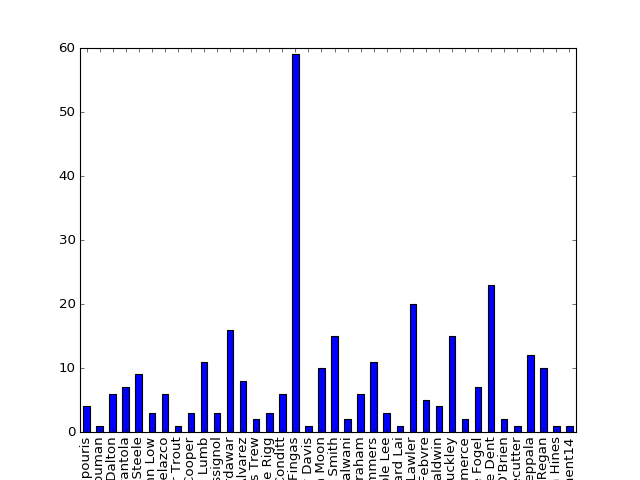

In [37]:
%matplotlib notebook
df.groupby("author").size().plot.bar()

A lot of other cool plotting methods can be found [here](http://pandas.pydata.org/pandas-docs/stable/visualization.html)

## Histogram of article lengths

<IPython.core.display.Javascript object>


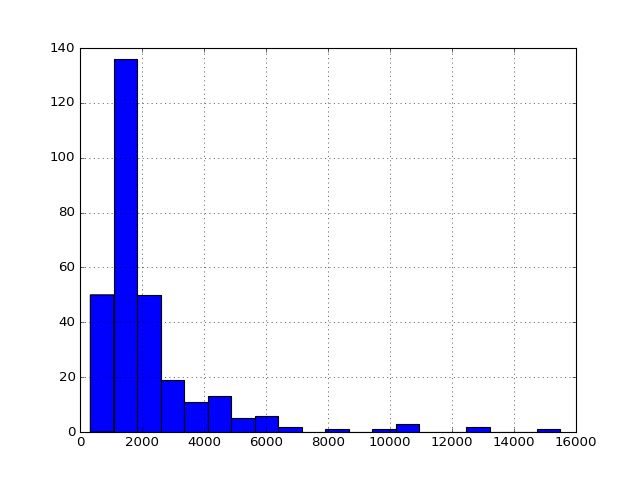

In [41]:
df["num_words"].hist(bins=20)